## Unsupervised Classification of Normal and Anomalous Sounds Using Autoencoder CNN and VAE

This script tests the ability of a **Convolutional Autoencoder (CNN)** and a **Variational Autoencoder (VAE)**  
to perform unsupervised anomaly detection by reconstructing normal sound data and identifying anomalous sounds  
based on reconstruction errors.

### Workflow:
1. **Training Phase**:  
   - The models are trained exclusively on **normal sound data**.
2. **Testing Phase**:  
   - The models are evaluated on a mix of **normal and anomalous sounds**.

### Assumption:
- Models trained to reconstruct normal data will produce **higher reconstruction errors** when encountering anomalous data.

---

### Limitations:
- **Dataset Size**: The current training dataset consists of **only 200 normal sound files**.  
  Even with data augmentation (about **400 samples**), this is insufficient for effective reconstruction learning.
- **Model Complexity**: Autoencoders and VAEs require large, diverse datasets to learn meaningful feature representations.  
  A small dataset can lead to **overfitting** and poor performance on unseen data.

---



## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from IPython.display import Image, display

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import os
#import cv2


## Show the gpu infos
... and change if needed in "Execution" panel

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 13 05:44:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import sys
print("Python version:", sys.version)


Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


## Import the spectrograms from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [58]:
import numpy as np
import os
import librosa
import librosa.display
import random

# Function to add noise
def add_noise(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

# Function to apply time stretching
def time_stretch(data, rate=1.1):
    return librosa.effects.time_stretch(data, rate)

# Function to apply pitch shifting
def pitch_shift(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# Function to adjust volume
def adjust_volume(data, factor=1.2):
    return data * factor

# Function to apply time shifting
def time_shift(data, shift_max=0.2):
    shift = int(random.uniform(-shift_max, shift_max) * len(data))
    return np.roll(data, shift)

# Function to create augmentations for a given file
def create_augmentations(file_path, output_folder, sr=22050, augmentations=3):
    # Load the original audio
    data = np.load(file_path)
    audio = librosa.feature.inverse.mel_to_audio(data, sr=sr)

    # Create augmentations
    for i in range(augmentations):
        augmented_audio = audio

        # Randomly apply augmentations
        if random.choice([True, False]):
            augmented_audio = add_noise(augmented_audio)
        if random.choice([True, False]):
            augmented_audio = pitch_shift(augmented_audio, sr, n_steps=random.randint(-2, 2))
        if random.choice([True, False]):
            augmented_audio = adjust_volume(augmented_audio, factor=random.uniform(0.8, 1.2))
        if random.choice([True, False]):
            augmented_audio = time_shift(augmented_audio)

        # Convert back to Mel spectrogram
        augmented_mel = librosa.feature.melspectrogram(y=augmented_audio, sr=sr)

        # Save the augmented data
        augmented_filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_aug_{i}.npy"
        augmented_filepath = os.path.join(output_folder, augmented_filename)
        np.save(augmented_filepath, augmented_mel)

# Path to the normal data folder
normal_data_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset_Melspectrograms/ChildrenPlayTrimmed'
output_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset_Melspectrograms/ChildrenPlayTrimmed_Augmented'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Process all normal .npy files in the folder
for file in os.listdir(normal_data_folder):
    if file.endswith('.npy'):
        file_path = os.path.join(normal_data_folder, file)
        create_augmentations(file_path, output_folder, sr=22050, augmentations=3)

## Build selection dataframe

The spectrogram are stored in the folder `Features/melspec_313_128/`. Each machine has its folder `fan/`, `valve/` etc... <br />
Each audio sample has its own mespectrogram flattened stored as a .npy file. So each file is one line of 313*128 = 40064 features.

We first build a dataframe df which gives us all the properties of the files. This will be used to select sounds according to their section, sound_type, etc ...

In [71]:
import os
import pandas as pd
import numpy as np

def build_selection_dataframe(folder_path):
    list_dict_file = []  # List of dictionaries for creating DataFrame

    # Define a helper function to process files from a folder
    def process_folder(folder_path):
        for subdirectory, _, files in os.walk(folder_path):
            # Extract the last part of the folder path (the folder name)
            folder_name = os.path.basename(subdirectory)

            # Determine if the folder is 'ChildrenPlayTrimmed', 'ChildrenPlayTrimmed_Augmented', or 'Conversation' (normal) or an anomaly folder
            sound_type = 'normal' if folder_name in ['ChildrenPlayTrimmed', 'ChildrenPlayTrimmed_Augmented', 'Conversation'] else 'anomaly'

            # Loop through files
            for file in files:
                if file.endswith('.npy'):  # Ensure we only process .npy files
                    path_file = os.path.join(subdirectory, file)
                    splitted_filename = file.split('_')

                    # Randomly assign some normal sounds to the test set or validation set
                    rand_val = np.random.rand()
                    if sound_type == 'normal':
                        if rand_val < 0.05:
                            dir_type = 'test'
                        elif rand_val < 0.15:
                            dir_type = 'val'
                        else:
                            dir_type = 'train'
                    else:
                        dir_type = 'test'

                    # Append dictionary to list
                    list_dict_file.append({
                        'filepath': path_file,
                        'type': dir_type,  # Use 'train', 'val', or 'test' based on assignment
                        'dir': dir_type,  # Normal for train, anomaly for test
                        'sound_type': sound_type,  # 'normal' or 'anomaly'
                        'id': path_file,  # Use path as unique ID
                        'suffix': '_'.join(splitted_filename[6:]).split('.npy')[0]  # Extract suffix
                    })

    # Process the folder
    process_folder(folder_path)

    # Convert to DataFrame
    df = pd.DataFrame(list_dict_file)

    return df

# Paths to the folder containing your data
folder_path = '/content/drive/MyDrive/Colab Notebooks/Dataset_Melspectrograms'

# Generate the combined DataFrame
df = build_selection_dataframe(folder_path)

# Display the generated DataFrame
print("Combined DataFrame:")
print(df.head())

# Show distribution of train/val/test and normal/anomaly
print("\nDistribution of Data:")
print(df.groupby(['dir', 'sound_type']).size())


Combined DataFrame:
                                            filepath   type    dir sound_type  \
0  /content/drive/MyDrive/Colab Notebooks/Dataset...  train  train     normal   
1  /content/drive/MyDrive/Colab Notebooks/Dataset...   test   test     normal   
2  /content/drive/MyDrive/Colab Notebooks/Dataset...  train  train     normal   
3  /content/drive/MyDrive/Colab Notebooks/Dataset...  train  train     normal   
4  /content/drive/MyDrive/Colab Notebooks/Dataset...  train  train     normal   

                                                  id suffix  
0  /content/drive/MyDrive/Colab Notebooks/Dataset...         
1  /content/drive/MyDrive/Colab Notebooks/Dataset...         
2  /content/drive/MyDrive/Colab Notebooks/Dataset...         
3  /content/drive/MyDrive/Colab Notebooks/Dataset...         
4  /content/drive/MyDrive/Colab Notebooks/Dataset...         

Distribution of Data:
dir    sound_type
test   anomaly       172
       normal         41
train  normal        582
val  

In [72]:
df['type'].value_counts()

,count
type,
train,582
test,213
val,53


## Data Generator

Since the datasets are quite big, let's make a data generator.<br/>

In [68]:
import torch
import numpy as np
import random

def data_generator(file_list, batch_size, device='cpu'):

    # Index used to go over file list
    index = 0

    # Infinite loop
    while True:

        # Case we looped over all the files
        if (index + 1) * batch_size >= len(file_list):
            # Reinitialize variables for a next round
            index = 0

            # Shuffle list to have different batches
            random.shuffle(file_list)

        # Get file paths for the current batch
        file_chunk = file_list[index * batch_size:(index + 1) * batch_size]

        # Init data list
        data = []

        # Loop over batch files
        for file in file_chunk:
            # Load the data and reshape it as necessary
            file_data = np.load(file).reshape(128, 431, 1)  # Assuming this shape is correct
            file_data = torch.tensor(file_data, dtype=torch.float32).to(device)  # Convert to PyTorch tensor

            data.append(file_data)

        # Convert list to PyTorch tensor
        data = torch.stack(data)  # Shape: (batch_size, 128, 431, 1)

        yield data  # Return only data for training or inference

        # Increment index
        index += 1


## RUN : predict the machine and deduce the sound type

### First model

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2)
        )

        # Bottleneck: Fully connected layer
        self.fc1 = nn.Linear(64 * 16 * 54, 128)  # Adjust dimensions according to your input size
        self.fc2 = nn.Linear(128, 64 * 16 * 54)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer

        # Bottleneck
        x = self.fc1(x)
        x = self.fc2(x)

        # Reshape back to feature map size
        x = x.view(x.size(0), 64, 16, 54)

        # Decode
        x = self.decoder(x)

        # Ensure output size matches the input size
        x = x[:, :, :128, :431]
        return x


In [99]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, device='cpu', epochs=20, gradient_clip=1.0, patience=5, save_path='best_model.pth'):
    model.to(device)

    train_loss_history = []
    val_loss_history = []

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        # Training loop with tqdm
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False) as t_train:
            for data, _ in t_train:  # Unpack data and ignore the labels
                data = data.to(device)
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data)

                # Compute reconstruction loss
                loss = criterion(outputs, data)
                loss.backward()

                # Gradient clipping to avoid exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)

                optimizer.step()

                running_train_loss += loss.item() * data.size(0)
                t_train.set_postfix(train_loss=loss.item())

        train_loss = running_train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0

        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False) as t_val:
            with torch.no_grad():
                for data, _ in t_val:
                    data = data.to(device)
                    outputs = model(data)
                    loss = criterion(outputs, data)
                    running_val_loss += loss.item() * data.size(0)
                    t_val.set_postfix(val_loss=loss.item())

        val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load the best model
    model.load_state_dict(torch.load(save_path))
    print("Best model loaded.")

    return train_loss_history, val_loss_history


In [100]:
from torch.utils.data import DataLoader, Dataset

class UnsupervisedDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, labels):
        self.filepaths = filepaths
        self.labels = labels  # 'normal' or 'anomaly'

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        data = np.load(self.filepaths[idx]).reshape(1, 128, 431).astype(np.float32)
        label = self.labels[idx]
        return torch.tensor(data), label

# Prepare file paths and labels
train_files = df[df['type'] == 'train']['filepath'].tolist()
val_files = df[df['type'] == 'val']['filepath'].tolist()
test_files = df[df['type'] == 'test']['filepath'].tolist()
test_labels = df[df['type'] == 'test']['sound_type'].tolist()  # 'normal' or 'anomaly'

# Create DataLoaders
train_loader = DataLoader(UnsupervisedDataset(train_files, ['normal'] * len(train_files)), batch_size=32, shuffle=True)
val_loader = DataLoader(UnsupervisedDataset(val_files, ['normal'] * len(val_files)), batch_size=32, shuffle=False)
test_loader = DataLoader(UnsupervisedDataset(test_files, test_labels), batch_size=32, shuffle=False)

In [101]:
# Initialize model, criterion, and optimizer
model = CNN_Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with validation and early stopping
train_loss_history, val_loss_history = train_autoencoder(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device='cuda',
    epochs=100,
    patience=5,
    save_path='best_autoencoder.pth'
)


Epoch [1/100] - Train Loss: 3819.0724, Val Loss: 3783.5139
Best model saved at epoch 1 with validation loss: 3783.5139


Epoch [2/100] - Train Loss: 3808.7709, Val Loss: 3777.4451
Best model saved at epoch 2 with validation loss: 3777.4451


Epoch [3/100] - Train Loss: 3803.6617, Val Loss: 3772.5982
Best model saved at epoch 3 with validation loss: 3772.5982


Epoch [4/100] - Train Loss: 3799.8187, Val Loss: 3770.3753
Best model saved at epoch 4 with validation loss: 3770.3753


Epoch [5/100] - Train Loss: 3796.4436, Val Loss: 3768.1764
Best model saved at epoch 5 with validation loss: 3768.1764


Epoch [6/100] - Train Loss: 3794.1384, Val Loss: 3765.0806
Best model saved at epoch 6 with validation loss: 3765.0806


Epoch [7/100] - Train Loss: 3792.3759, Val Loss: 3763.4037
Best model saved at epoch 7 with validation loss: 3763.4037


Epoch [8/100] - Train Loss: 3790.6949, Val Loss: 3762.1306
Best model saved at epoch 8 with validation loss: 3762.1306


Epoch [9/100] - Train Loss: 3789.4293, Val Loss: 3761.5921
Best model saved at epoch 9 with validation loss: 3761.5921


Epoch [10/100] - Train Loss: 3788.4128, Val Loss: 3760.8785
Best model saved at epoch 10 with validation loss: 3760.8785


Epoch [11/100] - Train Loss: 3787.7228, Val Loss: 3760.4410
Best model saved at epoch 11 with validation loss: 3760.4410


Epoch [12/100] - Train Loss: 3787.1395, Val Loss: 3760.3777
Best model saved at epoch 12 with validation loss: 3760.3777


Epoch [13/100] - Train Loss: 3786.8407, Val Loss: 3759.9560
Best model saved at epoch 13 with validation loss: 3759.9560


Epoch [14/100] - Train Loss: 3786.4598, Val Loss: 3759.7149
Best model saved at epoch 14 with validation loss: 3759.7149


Epoch [15/100] - Train Loss: 3786.2511, Val Loss: 3759.5589
Best model saved at epoch 15 with validation loss: 3759.5589


Epoch [16/100] - Train Loss: 3786.1062, Val Loss: 3759.3858
Best model saved at epoch 16 with validation loss: 3759.3858


Epoch [17/100] - Train Loss: 3785.8761, Val Loss: 3759.0412
Best model saved at epoch 17 with validation loss: 3759.0412


Epoch [18/100] - Train Loss: 3785.2488, Val Loss: 3758.1662
Best model saved at epoch 18 with validation loss: 3758.1662


Epoch [19/100] - Train Loss: 3784.8012, Val Loss: 3757.9601
Best model saved at epoch 19 with validation loss: 3757.9601


Epoch [20/100] - Train Loss: 3785.3601, Val Loss: 3758.0580


Epoch [21/100] - Train Loss: 3784.5997, Val Loss: 3757.9064
Best model saved at epoch 21 with validation loss: 3757.9064


Epoch [22/100] - Train Loss: 3784.4283, Val Loss: 3757.8473
Best model saved at epoch 22 with validation loss: 3757.8473


Epoch [23/100] - Train Loss: 3784.4007, Val Loss: 3757.8421
Best model saved at epoch 23 with validation loss: 3757.8421


Epoch [24/100] - Train Loss: 3784.3401, Val Loss: 3757.8192
Best model saved at epoch 24 with validation loss: 3757.8192


Epoch [25/100] - Train Loss: 3784.6325, Val Loss: 3757.8064
Best model saved at epoch 25 with validation loss: 3757.8064


Epoch [26/100] - Train Loss: 3784.4148, Val Loss: 3757.8051
Best model saved at epoch 26 with validation loss: 3757.8051


Epoch [27/100] - Train Loss: 3784.2964, Val Loss: 3757.7884
Best model saved at epoch 27 with validation loss: 3757.7884


Epoch [28/100] - Train Loss: 3784.2515, Val Loss: 3757.8009


Epoch [29/100] - Train Loss: 3784.2422, Val Loss: 3757.7779
Best model saved at epoch 29 with validation loss: 3757.7779


Epoch [30/100] - Train Loss: 3784.2456, Val Loss: 3757.7964


Epoch [31/100] - Train Loss: 3784.2300, Val Loss: 3757.7658
Best model saved at epoch 31 with validation loss: 3757.7658


Epoch [32/100] - Train Loss: 3784.2937, Val Loss: 3757.7692


Epoch [33/100] - Train Loss: 3784.2281, Val Loss: 3757.7644
Best model saved at epoch 33 with validation loss: 3757.7644


Epoch [34/100] - Train Loss: 3784.4835, Val Loss: 3757.7619
Best model saved at epoch 34 with validation loss: 3757.7619


Epoch [35/100] - Train Loss: 3784.3138, Val Loss: 3757.7659


Epoch [36/100] - Train Loss: 3784.2234, Val Loss: 3757.7634


Epoch [37/100] - Train Loss: 3784.5772, Val Loss: 3757.7547
Best model saved at epoch 37 with validation loss: 3757.7547


Epoch [38/100] - Train Loss: 3784.2936, Val Loss: 3757.7575


Epoch [39/100] - Train Loss: 3784.2116, Val Loss: 3757.7574


Epoch [40/100] - Train Loss: 3784.2065, Val Loss: 3757.7559


Epoch [41/100] - Train Loss: 3784.2033, Val Loss: 3757.7539
Best model saved at epoch 41 with validation loss: 3757.7539


Epoch [42/100] - Train Loss: 3784.2013, Val Loss: 3757.7518
Best model saved at epoch 42 with validation loss: 3757.7518


Epoch [43/100] - Train Loss: 3784.2000, Val Loss: 3757.7538


Epoch [44/100] - Train Loss: 3784.2008, Val Loss: 3757.7504
Best model saved at epoch 44 with validation loss: 3757.7504


Epoch [45/100] - Train Loss: 3784.4096, Val Loss: 3757.7513


Epoch [46/100] - Train Loss: 3784.3724, Val Loss: 3757.7500
Best model saved at epoch 46 with validation loss: 3757.7500


Epoch [47/100] - Train Loss: 3784.3231, Val Loss: 3757.7489
Best model saved at epoch 47 with validation loss: 3757.7489


Epoch [48/100] - Train Loss: 3784.2285, Val Loss: 3757.7517


Epoch [49/100] - Train Loss: 3784.2418, Val Loss: 3757.7498


Epoch [50/100] - Train Loss: 3784.1975, Val Loss: 3757.7470
Best model saved at epoch 50 with validation loss: 3757.7470


Epoch [51/100] - Train Loss: 3784.1928, Val Loss: 3757.7465
Best model saved at epoch 51 with validation loss: 3757.7465


Epoch [52/100] - Train Loss: 3784.1937, Val Loss: 3757.7478


Epoch [53/100] - Train Loss: 3784.3612, Val Loss: 3757.7471


Epoch [54/100] - Train Loss: 3784.1943, Val Loss: 3757.7494


Epoch [55/100] - Train Loss: 3784.1948, Val Loss: 3757.7501


Epoch [56/100] - Train Loss: 3784.2037, Val Loss: 3757.7461
Best model saved at epoch 56 with validation loss: 3757.7461


Epoch [57/100] - Train Loss: 3784.1921, Val Loss: 3757.7465


Epoch [58/100] - Train Loss: 3784.1971, Val Loss: 3757.7505


Epoch [59/100] - Train Loss: 3784.1862, Val Loss: 3757.7448
Best model saved at epoch 59 with validation loss: 3757.7448


Epoch [60/100] - Train Loss: 3784.1919, Val Loss: 3757.7465


Epoch [61/100] - Train Loss: 3784.1888, Val Loss: 3757.7467


Epoch [62/100] - Train Loss: 3784.1895, Val Loss: 3757.7451


Epoch [63/100] - Train Loss: 3784.1888, Val Loss: 3757.7451


Epoch [64/100] - Train Loss: 3784.1883, Val Loss: 3757.7441
Best model saved at epoch 64 with validation loss: 3757.7441


Epoch [65/100] - Train Loss: 3784.1915, Val Loss: 3757.7455


Epoch [66/100] - Train Loss: 3784.1876, Val Loss: 3757.7464


Epoch [67/100] - Train Loss: 3784.1874, Val Loss: 3757.7421
Best model saved at epoch 67 with validation loss: 3757.7421


Epoch [68/100] - Train Loss: 3784.1843, Val Loss: 3757.7414
Best model saved at epoch 68 with validation loss: 3757.7414


Epoch [69/100] - Train Loss: 3784.1895, Val Loss: 3757.7417


Epoch [70/100] - Train Loss: 3784.1813, Val Loss: 3757.7422


Epoch [71/100] - Train Loss: 3784.1835, Val Loss: 3757.7428


Epoch [72/100] - Train Loss: 3784.1801, Val Loss: 3757.7446


Epoch [73/100] - Train Loss: 3784.1799, Val Loss: 3757.7403
Best model saved at epoch 73 with validation loss: 3757.7403


Epoch [74/100] - Train Loss: 3784.1820, Val Loss: 3757.7453


Epoch [75/100] - Train Loss: 3784.1816, Val Loss: 3757.7415


Epoch [76/100] - Train Loss: 3784.1792, Val Loss: 3757.7397
Best model saved at epoch 76 with validation loss: 3757.7397


Epoch [77/100] - Train Loss: 3784.1822, Val Loss: 3757.7397


Epoch [78/100] - Train Loss: 3784.1789, Val Loss: 3757.7420


Epoch [79/100] - Train Loss: 3784.1797, Val Loss: 3757.7394
Best model saved at epoch 79 with validation loss: 3757.7394


Epoch [80/100] - Train Loss: 3784.1787, Val Loss: 3757.7394


Epoch [81/100] - Train Loss: 3784.1777, Val Loss: 3757.7390
Best model saved at epoch 81 with validation loss: 3757.7390


Epoch [82/100] - Train Loss: 3784.1777, Val Loss: 3757.7392


Epoch [83/100] - Train Loss: 3784.1775, Val Loss: 3757.7388
Best model saved at epoch 83 with validation loss: 3757.7388


Epoch [84/100] - Train Loss: 3784.1779, Val Loss: 3757.7386
Best model saved at epoch 84 with validation loss: 3757.7386


Epoch [85/100] - Train Loss: 3784.1804, Val Loss: 3757.7425


Epoch [86/100] - Train Loss: 3784.1784, Val Loss: 3757.7390


Epoch [87/100] - Train Loss: 3784.1783, Val Loss: 3757.7386


Epoch [88/100] - Train Loss: 3784.4454, Val Loss: 3757.7392


Epoch [89/100] - Train Loss: 3784.1935, Val Loss: 3757.7471
Early stopping triggered at epoch 89
Best model loaded.


<ipython-input-99-26629c97cdd9>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Using threshold (90th percentile): 8023.2097

Classification Report:
              precision    recall  f1-score   support

      normal       1.00      0.13      0.23       172
     anomaly       0.21      1.00      0.35        41

    accuracy                           0.30       213
   macro avg       0.61      0.56      0.29       213
weighted avg       0.85      0.30      0.25       213


Confusion Matrix:
[[ 41   0]
 [150  22]]


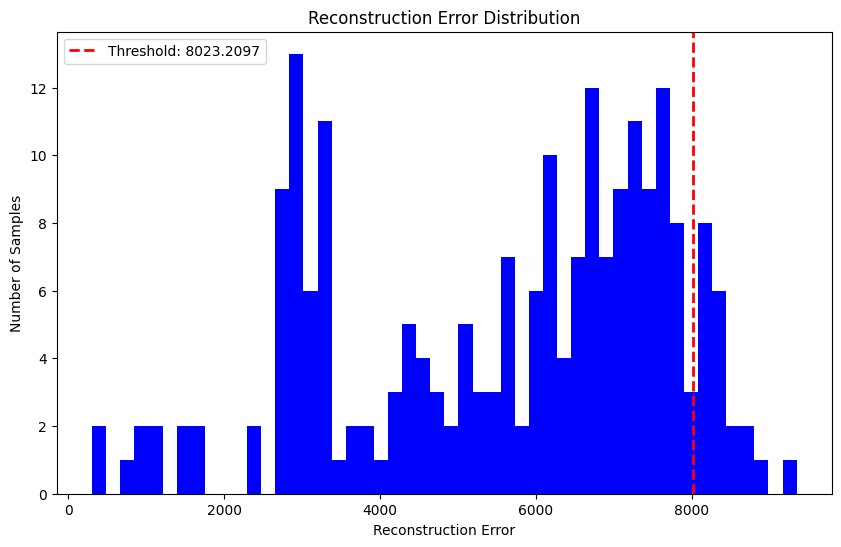

In [102]:
from sklearn.metrics import classification_report, confusion_matrix

def test_autoencoder(model, test_loader, device='cuda', threshold=None):
    model.to(device)
    model.eval()

    reconstruction_errors = []
    true_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            true_labels.extend(labels)

            # Forward pass
            outputs = model(data)

            # Compute reconstruction error (Mean Squared Error per sample)
            error = torch.mean((outputs - data) ** 2, dim=[1, 2, 3])
            reconstruction_errors.extend(error.cpu().numpy())

    # If threshold is not provided, set it as the 90th percentile of errors
    if threshold is None:
        threshold = np.percentile(reconstruction_errors, 90)
        print(f"Using threshold (90th percentile): {threshold:.4f}")

    # Identify anomalies based on the threshold
    predictions = ['anomaly' if error > threshold else 'normal' for error in reconstruction_errors]

    # Calculate performance metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=['normal', 'anomaly']))

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=['normal', 'anomaly'])
    print("\nConfusion Matrix:")
    print(cm)

    # Plot the distribution of reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors, bins=50, color='blue')
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.4f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Number of Samples')
    plt.title('Reconstruction Error Distribution')
    plt.legend()
    plt.show()

    return reconstruction_errors, threshold

# Call the testing function
reconstruction_errors, threshold = test_autoencoder(model, test_loader)


In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(CNN_VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2)
        )

        # Compute the flattened dimension after the encoder
        self.flatten_dim = 64 * 16 * 54  # Adjust this based on your input size

        # Latent space
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 64, 16, 54)
        x = self.decoder(x)
        return x[:, :, :128, :431]

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE) with mean reduction
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalize KL divergence by batch size
    kl_divergence /= x.size(0)

    return recon_loss + kl_divergence


In [109]:
from tqdm import tqdm
import torch

def train_vae(model, train_loader, val_loader, optimizer, device='cuda', epochs=20, gradient_clip=1.0, patience=5, save_path='best_vae_model.pth'):
    model.to(device)

    train_loss_history = []
    val_loss_history = []

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        # Training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=True) as t_train:
            for data, _ in t_train:
                data = data.to(device)
                optimizer.zero_grad()

                # Forward pass
                recon_data, mu, logvar = model(data)

                # Compute VAE loss
                loss = vae_loss(recon_data, data, mu, logvar)
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)

                optimizer.step()

                running_train_loss += loss.item()
                t_train.set_postfix(train_loss=loss.item())

        train_loss = running_train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0

        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=True) as t_val:
            with torch.no_grad():
                for data, _ in t_val:
                    data = data.to(device)
                    recon_data, mu, logvar = model(data)
                    loss = vae_loss(recon_data, data, mu, logvar)
                    running_val_loss += loss.item()
                    t_val.set_postfix(val_loss=loss.item())

        val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load the best model
    model.load_state_dict(torch.load(save_path))
    print("Best model loaded.")

    return train_loss_history, val_loss_history


In [115]:
# Initialize the VAE model
vae_model = CNN_VAE(latent_dim=128)

# Define the optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001)

# Train the VAE with the modified function
train_loss_history, val_loss_history = train_vae(
    vae_model,
    train_loader,
    val_loader,
    optimizer,
    device='cuda',
    epochs=20,
    patience=5,
    save_path='best_vae_model.pth'
)

Epoch 1/20 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s, val_loss=3.12e+3]


Epoch [1/20] - Train Loss: 128.0569, Val Loss: 139.2510
Best model saved at epoch 1 with validation loss: 139.2510


Epoch 2/20 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s, val_loss=3.13e+3]


Epoch [2/20] - Train Loss: 126.5634, Val Loss: 139.4761


Epoch 3/20 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  8.53it/s, val_loss=3.14e+3]


Epoch [3/20] - Train Loss: 127.5543, Val Loss: 139.7127


Epoch 4/20 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, val_loss=3.14e+3]


Epoch [4/20] - Train Loss: 124.2891, Val Loss: 139.7476


Epoch 5/20 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s, val_loss=3.14e+3]


Epoch [5/20] - Train Loss: 125.6154, Val Loss: 139.6970


Epoch 6/20 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s, val_loss=3.14e+3]

Epoch [6/20] - Train Loss: 125.9004, Val Loss: 139.7341
Early stopping triggered at epoch 6
Best model loaded.



<ipython-input-109-c279d52f2c55>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [116]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def test_vae(model, test_loader, device='cuda', threshold=None):
    model.to(device)
    model.eval()

    reconstruction_errors = []
    true_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            true_labels.extend(labels)

            # Forward pass
            recon_data, mu, logvar = model(data)

            # Compute reconstruction error (Mean Squared Error per sample)
            error = torch.mean((recon_data - data) ** 2, dim=[1, 2, 3])
            reconstruction_errors.extend(error.cpu().numpy())

    # Convert labels to numpy array
    true_labels = np.array(true_labels)

    # Plot the distribution of reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors, bins=50, color='blue')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Number of Samples')
    plt.title('Reconstruction Error Distribution')
    plt.show()

    # If threshold is not provided, set it as the 90th percentile of errors
    if threshold is None:
        threshold = np.percentile(reconstruction_errors, 90)
        print(f"Using threshold (90th percentile): {threshold:.4f}")

    # Identify anomalies based on the threshold
    predictions = ['anomaly' if error > threshold else 'normal' for error in reconstruction_errors]

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=['normal', 'anomaly']))

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=['normal', 'anomaly'])
    print("\nConfusion Matrix:")
    print(cm)

    return reconstruction_errors, threshold


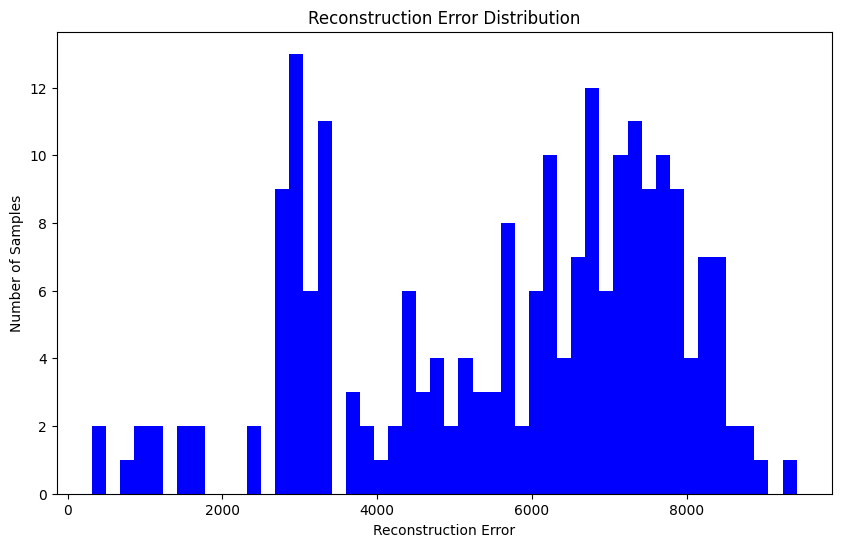

Using threshold (90th percentile): 8092.9188

Classification Report:
              precision    recall  f1-score   support

      normal       1.00      0.13      0.23       172
     anomaly       0.21      1.00      0.35        41

    accuracy                           0.30       213
   macro avg       0.61      0.56      0.29       213
weighted avg       0.85      0.30      0.25       213


Confusion Matrix:
[[ 41   0]
 [150  22]]


In [117]:
reconstruction_errors, threshold = test_vae(vae_model, test_loader)
